In [1]:
import torch
from torchvision import datasets, transforms

In diesem Beispiel sehen wir uns MNIST an.
Hierbei handelt es sich um eine Datenbank aus
70000 handgeschriebenen Ziffern, davon 60000 im Trainings-
und 10000 im Testdatensatz.

In [2]:
train_set = datasets.MNIST("data", train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.MNIST("data", train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))

Diesen Datensatz packen wir nun in einen passenden `DataLoader`.
Mit diesem können wir gut über Datensätze iterieren.

In [3]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

Das erste Element des DataLoaders sieht wie folgt aus:

In [5]:
fst_data = next(iter(train_loader))
print(fst_data)

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

Betrachten beispielhaft wir die erste Ziffer.

Text(0.5, 1.0, 'Value: 8')

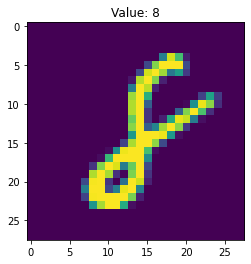

In [6]:
fst_image = fst_data[0][0]
fst_digit = fst_data[1][0].item()

import matplotlib.pyplot as plt
plt.imshow(fst_image.view(fst_image.shape[1], fst_image.shape[2]))
plt.title(f"Value: {fst_digit}")

### Logistische Regression
Nun erstellen wir die Architektur der logistischen Regression.

<img src="assets/fcnn-28x28-64-10.svg"/>

In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, 64)
        self.fc2 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.log_softmax(self.fc2(x), dim=1)
        return x

In [9]:
lr_rate = 0.01

In [10]:
model = LogisticRegression()
model

LogisticRegression(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

Jetzt initialisieren wir die Loss class und den Optimizer (Stochastic Gradient Descent).

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [12]:
def calculate_accuracy(loader):
    correct = 0
    total = 0
    for images_test, labels_test in loader:
        images_test = Variable(images_test.view(-1, 28*28))
        outputs = model(images_test)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_test.size(0)
        correct += (predicted == labels_test).sum()
    acc = correct.item() / total
    return acc

In [13]:
from torch.autograd import Variable

for epoch in range(3):
    print(f"Epoch {epoch+1}/3")
    for i, (images, labels) in enumerate(train_loader):
        # we use torch.autograd.Variable for backpropagation
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    test_accuracy = calculate_accuracy(test_loader)
    print(f"Loss: {loss.item():.5f}. Test Accuracy: {test_accuracy:.3f}.")

Epoch 1/3
Loss: 0.82982. Test Accuracy: 0.826.
Epoch 2/3
Loss: 0.51943. Test Accuracy: 0.873.
Epoch 3/3
Loss: 0.36164. Test Accuracy: 0.891.
